# Übungen Convolutional Neuronal Networks (Hausaufgabe #4)

## Aufgabe

1. Eigene Bilddaten finden
2. Folgende Parameter zu testen in Hinblick auf besssere Accuracy und Reduzierung von Overfitting
   - Wieviele Conv2d layer überhaupt?
   - Anzahl der Kernels pro Layer (output channels)
   - Grösse der Kernels
   - Transforms nach wahl (minimum "to_tensor")
   - Mit und ohne Batch-Normalization
   - Wieviel dropout (in prozent z.B. 0.25) ist optimal gegen Overfitting)
   - Stride Grösse (1 und mehr)

Zusatzinformationen:

- padding = same
- Bilder nicht all zu gross
- Bestes model speichern
- Inference mit einem Bild

## Übungssetup

### Teammitglieder Gruppe 3

- Hans Wermelinger
- Helmut Gehrer
- Markus Näpflin
- Nils Hryciuk
- Stefano Mavilio

### Laufzeitumgebung

Damit dieses Jupyter-Notebook ausgeführt werden kann, müssen folgende Module im aktuellen Python-Environment verfügbar sein:

- numpy
- math
- torch
- matplotlib
- pandas
- ucimlrepo
- torchviz

Alternativ kann es auch auf [Google Collab](https://colab.research.google.com/drive/1tohtPXhmdNVGt63S1VPErbeQK1YJNoMr?usp=sharing#scrollTo=78b7wKOj-hwB) ausgeführt werden.

## Lösungsweg

### Daten

#### Herkunft

[Kaggle - 70 Dog Breeds-Image Data Set](https://www.kaggle.com/datasets/gpiosenka/70-dog-breedsimage-data-set/data)
#### Context

I own a dog grooming business. A lot of customers don't know the breed of their dog. I am no expert either so I developed an AI program that can identify the breed of a dog from a photo. It works well for pure bred dogs and also seems to work reasonably well for mixed breeds. For each prediction I list the probability of the most likely breed and the probability of the next most likely breed. I tried that on my dog who is a mix of a Rottweiler and a Doberman. It came back that there as a 62% probability it was a Rottweiler and a 28% probability it was a Doberman.

#### Content

Data was gathered from internet searches on a specific dog breed. Images were than downloaded and checked for accuracy as not all the images you get in a search are correct. Then the downloaded images were scanned for duplicates using a duplicate image detection program I developed. All duplicates were removed to prevent any images being duplicate across the test, train and validation sets. Images were then resized to 224 X 224 X 3 and put in jpg format.

### Vorbereitung Notebook


#### Generelle Hinweise

ℹ️ Wenn alle parametrisierten Tests ausgeführt werden sollen, ist eine Runtimeumgebung **mit GPU** empfehlenswert. Steht keine zur Verfügung, dann sollten einige Testszenarien in config.csv entfernt werden.

#### Zusatzpakete installieren

In [ ]:
!!pip install torchmetrics

['Collecting torchmetrics',
 '  Downloading torchmetrics-1.6.0-py3-none-any.whl.metadata (20 kB)',
 'Requirement already satisfied: numpy>1.20.0 in /usr/local/lib/python3.10/dist-packages (from torchmetrics) (1.26.4)',
 'Requirement already satisfied: packaging>17.1 in /usr/local/lib/python3.10/dist-packages (from torchmetrics) (24.2)',
 'Requirement already satisfied: torch>=2.0.0 in /usr/local/lib/python3.10/dist-packages (from torchmetrics) (2.5.1+cu121)',
 'Collecting lightning-utilities>=0.8.0 (from torchmetrics)',
 '  Downloading lightning_utilities-0.11.8-py3-none-any.whl.metadata (5.2 kB)',
 'Requirement already satisfied: setuptools in /usr/local/lib/python3.10/dist-packages (from lightning-utilities>=0.8.0->torchmetrics) (75.1.0)',
 'Requirement already satisfied: typing-extensions in /usr/local/lib/python3.10/dist-packages (from lightning-utilities>=0.8.0->torchmetrics) (4.12.2)',
 'Requirement already satisfied: filelock in /usr/local/lib/python3.10/dist-packages (from torc

#### Generelle Konfigurationen

Importe, globale Konsatenten und Konfigurationen der wichtigsten eingesetzten Frameworks.

In [ ]:
# -*- coding: utf-8 -*-
# --- Generelle Importe; spezifische werden näher bei der Nutzung importiert ---
import os
import math
import datetime
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
print('Importe abgeschlossen')
print(f'- PyTorch version: {torch.__version__}')


Importe abgeschlossen
- PyTorch version: 2.5.1+cu121


In [ ]:
# --- Diverse Konstanten vordefinieren ---
WORKING_PATH = './M05_CNN_G3' # Verzeichnis für Modell und Konfiguration
DATA_PATH = WORKING_PATH + '/data' # Verzeichnis für Daten
MODEL_DTYPE = torch.float # Datentyp für Tensoren
DEFAULT_SEED = 42 # Konstante für reproduzierbare Zufahlszahlen
IMAGE_EDGE_LENGTH = 224 # Kantenlänge der quadratischen Bilder in Pixel.

print('Following constants have been initialized:')
print(f'- WORKING_PATH: {WORKING_PATH}')
print(f'- DATA_PATH: {DATA_PATH}')
print(f'- MODEL_DTYPE: {MODEL_DTYPE}')
print(f'- DEFAULT_SEED: {DEFAULT_SEED}')
print(f'- IMAGE_SIZE (IMAGE_EDGE_SIZE): {IMAGE_EDGE_LENGTH}x{IMAGE_EDGE_LENGTH} pxl')

NameError: name 'torch' is not defined

Konfiguration von PyTorch und Mathplotlib

In [ ]:
# --- Konfiguration von PyTorch ---
FASTEST_DEVICE = {
    torch.cuda.is_available(): 'cuda', # GPU
    torch.backends.mps.is_available(): 'mps' # Metal-Performance-Service, z.B. Mac Mx;
}.get(True, 'cpu')
torch.set_default_device(FASTEST_DEVICE)
torch.set_default_dtype(MODEL_DTYPE)
torch.manual_seed(DEFAULT_SEED)

print('Torch has bee configured as follows:')
print(f'- seed: {DEFAULT_SEED}')
print(f'- fastest device: {FASTEST_DEVICE}')
# --- Plotter initialisieren inkl. Inline-Ausgabe der Grafiken ---
plt.rcdefaults()
%matplotlib inline
print('Matplotlib has been configured for inline display.')

NameError: name 'torch' is not defined

#### Persistenz von Konfiguration und Metriken

Wir haben beschlossen, die Konfiguration und die Ablage der Metriken in ein Konfigurationsfile auszulagern. Dies ermöglicht es uns, mit verschiedenen Parametern zu experimentieren und immer den Gesamtkontext im Blick zu haben.

In [ ]:
CONFIG_FILE = WORKING_PATH + '/config.csv'
# Struktur des CSV-Files definieren
config_record = {
    'label': 'str',
    'epochs': 'int',
    'batch_size': 'int',
    'image_edge_length': 'int',
    'kernel_1_size': 'int',
    'kernel_1_stride': 'int',
    'kernel_1_out': 'int',
    'kernel_2_size': 'int',
    'kernel_2_stride': 'int',
    'kernel_2_out': 'int',
    'hidden_layer_1_nodes': 'int',
    'hidden_layer_2_nodes': 'int',
    'optimizer': 'str',
    'loss_function': 'str'
}

if not os.path.exists(WORKING_PATH):
    os.makedirs(WORKING_PATH)

if not os.path.exists(CONFIG_FILE):
    config = pd.DataFrame(columns=config_record.keys())
    run_1 = {'label': 'Grösse 1/4 SGD/CrossEntropy', 'epochs': 5, 'batch_size': 10, 'image_edge_length': 56, 'kernel_1_size': 3, "kernel_1_stride": 1, "kernel_2_size": 0, "hidden_layer_1_nodes": 512, "optimizer": "SGD", "loss_function": "CrossEntropyLoss" }
    config = config._append(run_1, ignore_index=True)
    run_2 = {'label': 'Grösse 1/4  SGD/MSE', 'epochs': 3, 'batch_size': 10, 'image_edge_length': 56, 'kernel_1_size': 3, "kernel_1_stride": 1, "kernel_2_size": 0, "hidden_layer_1_nodes": 512, "optimizer": "SGD", "loss_function": "MSELoss" }
    config = config._append(run_2, ignore_index=True)
    run_3 = {'label': 'Grösse 1/4  SGD/NLL', 'epochs': 3, 'batch_size': 10, 'image_edge_length': 56, 'kernel_1_size': 3, "kernel_1_stride": 1, "kernel_2_size": 0, "hidden_layer_1_nodes": 512, "optimizer": "SGD", "loss_function": "NLLLoss" }
    config = config._append(run_3, ignore_index=True)
    run_4 = {'label': 'Grösse 1/4  Adam/CrossEntropy', 'epochs': 3, 'batch_size': 10, 'image_edge_length': 56, 'kernel_1_size': 3, "kernel_1_stride": 1, "kernel_2_size": 0, "hidden_layer_1_nodes": 512, "optimizer": "Adam", "loss_function": "CrossEntropyLoss" }
    config = config._append(run_4, ignore_index=True)
    run_5 = {'label': 'Grösse 1/2  SGD/CrossEntropy', 'epochs': 3, 'batch_size': 10, 'image_edge_length': 112, 'kernel_1_size': 3, "kernel_1_stride": 1, "kernel_2_size": 0, "hidden_layer_1_nodes": 512 , "optimizer": "SGD", "loss_function": "CrossEntropyLoss"}
    config = config._append(run_5, ignore_index=True)
    run_6 = {'label': 'Grösse 1/4  Adam/CrossEntropy ohne Batches', 'epochs': 3, 'batch_size': 1, 'image_edge_length': 56, 'kernel_1_size': 3, "kernel_1_stride": 1, "kernel_2_size": 0, "hidden_layer_1_nodes": 512 , "optimizer": "Adam", "loss_function": "CrossEntropyLoss"}
    config = config._append(run_6, ignore_index=True)
    run_7 = {'label': 'Grösse 1/4  Adam/CrossEntropy grosse Batches', 'epochs': 10, 'batch_size': 100, 'image_edge_length': 56, 'kernel_1_size': 3, "kernel_1_stride": 1, "kernel_2_size": 0, "hidden_layer_1_nodes": 512 , "optimizer": "Adam", "loss_function": "CrossEntropyLoss"}
    config = config._append(run_7, ignore_index=True)
    run_8 = {'label': 'Grösse 1/4  Adam/CrossEntropy 2 Kernel', 'epochs': 10, 'batch_size': 100, 'image_edge_length': 56, 'kernel_1_size': 3, "kernel_1_stride": 1, "kernel_2_size": 5, "kernel_2_stride": 2, "hidden_layer_1_nodes": 512 , "optimizer": "Adam", "loss_function": "CrossEntropyLoss"}
    config = config._append(run_7, ignore_index=True)
    config.to_csv(CONFIG_FILE)
else:
    config = pd.read_csv(CONFIG_FILE, dtype=config_record)

print('Running multiple batches with following configs:')
print(config)


Running multiple batches with following configs:
                                          label epochs batch_size  \
0                   Grösse 1/4 SGD/CrossEntropy      5         10   
1                           Grösse 1/4  SGD/MSE      3         10   
2                           Grösse 1/4  SGD/NLL      3         10   
3                 Grösse 1/4  Adam/CrossEntropy      3         10   
4                  Grösse 1/2  SGD/CrossEntropy      3         10   
5    Grösse 1/4  Adam/CrossEntropy ohne Batches      3          1   
6  Grösse 1/4  Adam/CrossEntropy grosse Batches     10        100   
7  Grösse 1/4  Adam/CrossEntropy grosse Batches     10        100   

  image_edge_length kernel_1_size kernel_1_stride kernel_1_out kernel_2_size  \
0                56             3               1          NaN             0   
1                56             3               1          NaN             0   
2                56             3               1          NaN             0   
3        

In [ ]:
STATISTICS_FILE = WORKING_PATH + '/statistics.json'

statistics_record = {
    'label': 'str',
    'config': 'str',
    'trained_at': 'datetime64',
    'training_time': 'float',
    'train_loss': 'float',
    'train_accuracy': 'float',
    'test_loss': 'float',
    'test_accuracy': 'float'
}

if not os.path.exists(WORKING_PATH):
    os.makedirs(WORKING_PATH)

if os.path.exists(STATISTICS_FILE):
    statistics = pd.read_json(STATISTICS_FILE, dtype=statistics_record)

def add_and_store_statstics(label: str, config: str,  trained_at: str,  training_time: float, train_loss: float, train_accuracy: float, test_loss: float, test_accuracy: float ):
    # todo: record erstellen und ergänezn
    config.to_json(STATISTICS_FILE)


### Herunterladen der Daten von Kagglehub
Laden des Datasets direkt von Kaggle.com mithilfe des verfügbaren Loaders aus dem Modul kagglehub.

- Ist das Datenverzeichnis bereits vorhanden, so wird der Download nicht noch einmal angestossen.
- Die **Version** des Datasets ist **fixiert**. Soll einfach die neuste Version heruntergeladen werden, so kann die Download-URL auf `gpiosenka/70-dog-breedsimage-data-set` angepasst werden.

In [ ]:
import kagglehub

if not os.path.exists(DATA_PATH):
    download_path = kagglehub.dataset_download('gpiosenka/70-dog-breedsimage-data-set/versions/2')
    os.makedirs(DATA_PATH)
    os.rename(download_path, DATA_PATH)
    print(f'Dataset files have been downloaded to {DATA_PATH}.')
else:
    print(f'Dataset files already exist in "{DATA_PATH}". You have to remove them first, if you want a fresh download.')

100%|██████████| 215M/215M [00:04<00:00, 55.7MB/s]

Extracting files...


Dataset files have been downloaded to ./M05_CNN_G3/data.


### Laden des Datasets inkl Split train/valid/test

#### Funktion zum Transformieren der Daten und Bereitstellung als Loader

Diese Funktion stellt die vorgängig herungergeladenen Daten aus dem Verezichnis als Dataloader bereit. Dabei werden die Daten

- transformiert (Resize konfigurierbar)
- in drei Dataloaders (trein / test / validate) bereitgestellt. Die Batchgrösse ist hier ebenfalls konfigurierbar.

In [ ]:
# --- Datensets train / validate / test laden ---
def prepare_dataloaders(batch_size=5, edge_length=IMAGE_EDGE_LENGTH, crop_size = IMAGE_EDGE_LENGTH):
    data_transforms = {
        'train': transforms.Compose([
            transforms.CenterCrop(crop_size),
            transforms.Resize(edge_length),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'valid': transforms.Compose([
            transforms.CenterCrop(crop_size),
            transforms.Resize(edge_length),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.CenterCrop(crop_size),
            transforms.Resize(edge_length),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

    generator = torch.Generator(device=FASTEST_DEVICE)
    generator.manual_seed(DEFAULT_SEED)

    image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_PATH, x), data_transforms[x]) for x in ['train', 'valid', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, generator=generator, num_workers=0) for x in ['train', 'valid', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
    class_names = image_datasets['train'].classes
    return dataloaders, class_names

#### Testen des Dataloaders

Aufruf der Funktion und anzeige eines Batches Bilder aus dem Trainingsdatensatz.

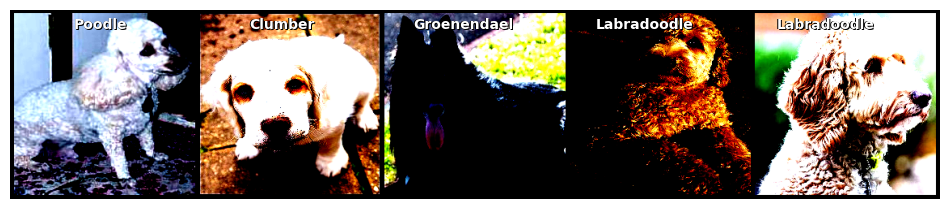

In [ ]:
# functions to show an image
def add_image_to_grid(image):
    image = image / 2 + 0.5     # unnormalize
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

debug_dataloaders, debug_dog_breeds = prepare_dataloaders()
#debug_dataloaders, debug_dog_breeds = prepare_dataloaders(batch_size=15, edge_length=112)
debug_images, debug_labels = next(iter(debug_dataloaders['train']))
grid_img = torchvision.utils.make_grid(debug_images, nrow=5, padding=5)

plt.figure(figsize=(12, 6))
plt.imshow(grid_img.permute(1, 2, 0))  # permute für korrektes Format (H, W, C)
plt.axis('off')

# Labels unter den Bildern anbringen
num_images = len(debug_labels)
nrow = 5
for i in range(num_images):
    row = i // nrow
    col = i % nrow
    x_pos = col * (debug_images.size(3)) + debug_images.size(3) // 2
    y_pos = row * debug_images.size(2) + 10
    # Test mit Umrandung rendern durch versetztes Plotten.
    plt.text(x_pos-1, y_pos-1, debug_dog_breeds[debug_labels[i]], ha='center', va='top', color='black', fontsize=10, fontweight='bold')
    plt.text(x_pos+1, y_pos+1, debug_dog_breeds[debug_labels[i]], ha='center', va='top', color='black', fontsize=10, fontweight='bold')
    plt.text(x_pos, y_pos, debug_dog_breeds[debug_labels[i]], ha='center', va='top', color='white', fontsize=10, fontweight='bold')

plt.show()

### Defintion des Modells

#### Modellklasse DogBreedRecognitionModel

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class DogBreedRecognitionModel(nn.Module):
    def __init__(self,image_edge_length=IMAGE_EDGE_LENGTH, color_channels=3, kernel_1_size=3, kernel_1_stride=1, kernel_1_out=6, kernel_2_size=0, kernel_2_stride=1, kernel_2_out=12, hidden_layer_1_nodes=1024, hidden_layer_2_nodes=0, output_size=70):
        super().__init__()
        if (output_size == 0):
            raise ValueError(f'output_size darf nicht {output_size} sein!')
        print('Erstelle neue Instanz von DogBreedRecognitionModel:')
        features_after_convolutional = image_edge_length
        print(f'- Input: {color_channels}x{image_edge_length}x{image_edge_length}')
        if kernel_1_size > 0:
            self.convolutional_1 = nn.Conv2d(color_channels, kernel_1_out, kernel_1_size, stride=kernel_1_stride, padding=kernel_1_stride)
            print(f'- Convolutional layer 1: {color_channels} channels --> {kernel_1_out} channels with kernel sized {kernel_1_size} pxl')
            features_after_convolutional = ((features_after_convolutional + 2 * kernel_1_stride - kernel_1_size) // kernel_1_stride + 1)
            self.pool1 = nn.MaxPool2d(kernel_size=kernel_1_size, stride=kernel_1_stride, padding=kernel_1_stride)
        else:
            self.convolutional_1 = None
        if kernel_2_size > 0:
            self.convolutional_2 = nn.Conv2d(kernel_1_out, kernel_2_out, kernel_2_size, stride=kernel_2_stride, padding=kernel_2_stride)
            print(f'- Convolutional layer 2: {kernel_1_out} channels --> {kernel_2_out} channels with kernel sized {kernel_2_size} pxl ')
            features_after_convolutional = ((features_after_convolutional + 2 * kernel_2_stride - kernel_2_size) // kernel_2_stride + 1)
            self.pool2 = nn.MaxPool2d(kernel_size=kernel_2_size, stride=kernel_2_stride, padding=kernel_2_stride)
        else:
            self.convolutional_2 = None

        flattened_features = features_after_convolutional ** 2 * kernel_1_out
        print(f'- Flattened features for Dense layer: {flattened_features}')

        features_after_hiddenlayers = flattened_features
        if hidden_layer_1_nodes > 0:
            self.hidden_layer_1 = nn.Linear(flattened_features, hidden_layer_1_nodes)
            features_after_hiddenlayers = hidden_layer_1_nodes
            print(f'- Hidden layer 1: {features_after_convolutional} features --> {hidden_layer_1_nodes} nodes')
        else:
            self.hidden_layer_1 = None
            features_after_hiddenlayers = flattened_features

        if hidden_layer_2_nodes > 0:
            self.hidden_layer_2 = nn.Linear(features_after_hiddenlayers, hidden_layer_2_nodes)
            features_after_hiddenlayers = hidden_layer_2_nodes
            print(f'- Hidden layer 2: {features_after_hiddenlayers} nodes --> {hidden_layer_2_nodes} nodes')
        else:
            self.hidden_layer_2 = None
        self.output_layer = nn.Linear(features_after_hiddenlayers, output_size)
        print(f'- Output layer: {features_after_hiddenlayers} nodes --> {output_size} target probabilities')

        #print('Resulting model:')
        #for name, params in self.named_parameters():
        #    print(f'- {name}: {params.size()}')


    def forward(self, x):
        if self.convolutional_1:
            x = self.pool1(F.relu(self.convolutional_1(x)))
        if self.convolutional_2:
            x = self.pool2(F.relu(self.convolutional_2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        if self.hidden_layer_1:
            # todo: Normalisierung prüfen (Nils)!
            x = F.relu(self.hidden_layer_1(x))
        if self.hidden_layer_2:
            # todo: Normalisierung prüfen (Nils)!
            x = F.relu(self.hidden_layer_2(x))
        return self.output_layer(x)

#### Debugging und Analyse der Modellklasse

Ein forward wird hier manuell durchgespielt und alle Zwischenergebenisse ausgegeben. Datenbasis ist der debug_dataloader aus dem Test des Dataloaders.

In [ ]:
def print_tensor(tensor_name, tensor):
    print(f'----- {tensor_name} -----')
    print(f'Typ: {tensor.type()}  Datentyp: {tensor.dtype} Grösse: {tensor.size()}')
    #print(f"Beginn: {tensor[0]}")
    #print(f"Ende: {tensor[-1]}")
    #print(tensor) # alles ausgeben
debug_model = DogBreedRecognitionModel()
# Sicherstellen, dass alles auf dem gleichen Device instanziert ist (falls GPU genutzt wird)
debug_images = debug_images.to(FASTEST_DEVICE)
debug_model = debug_model.to(FASTEST_DEVICE)

print_tensor('debug_images', debug_images)
#debug_image = debug_images[0]
#print_tensor('debug_image', debug_image)

# Log -Output Schritt für Schritt für Kernel 1
debug_after_kernel1 = debug_model.convolutional_1(debug_images)
print_tensor('debug_after_kernel1', debug_after_kernel1)
debug_after_kernel1 = F.relu(debug_after_kernel1)
print_tensor('debug_after_kernel1_relu', debug_after_kernel1)
debug_after_kernel1 = debug_model.pool1(debug_after_kernel1)
print_tensor('debug_after_kernel1_pool1', debug_after_kernel1)

# Log -Output Schritt für Schritt für Kernel 2
if debug_model.convolutional_2:
    debug_after_kernel2 = debug_model.convolutional_2(debug_after_kernel1)
    print_tensor('debug_after_kernel2', debug_after_kernel2)
    debug_after_kernel2 = F.relu(debug_after_kernel2)
    print_tensor('debug_after_kernel2_relu', debug_after_kernel2)
    debug_after_kernel2 = debug_model.pool2(debug_after_kernel2)
    print_tensor('debug_after_kernel2_pool2', debug_after_kernel2)
else:
    debug_after_kernel2 = debug_after_kernel1

# Image flachdrücken
debug_after_flatten = torch.flatten(debug_after_kernel2, 1)
print_tensor('debug_after_flatten', debug_after_flatten)

# Hidden Layer ...
if debug_model.hidden_layer_1:
    debug_after_hidden1 = F.relu(debug_model.hidden_layer_1(debug_after_flatten))
    print_tensor('debug_after_hidden1', debug_after_hidden1)
else:
    debug_after_hidden1 = debug_after_flatten
if debug_model.hidden_layer_2:
    debug_after_hidden2 = F.relu(debug_model.hidden_layer_2(debug_after_hidden1))
    print_tensor('debug_after_hidden2', debug_after_hidden2)
else:
    debug_after_hidden2 = debug_after_hidden1
# und Output Layer
debug_after_output = debug_model.output_layer(debug_after_hidden2)
print_tensor('debug_after_output', debug_after_output)

Erstelle neue Instanz von DogBreedRecognitionModel:
- Input: 3x224x224
- Convolutional layer 1: 3 channels --> 6 channels with kernel sized 3 pxl
- Flattened features for Dense layer: 301056
- Hidden layer 1: 224 features --> 1024 nodes
- Output layer: 1024 nodes --> 70 target probabilities
----- debug_images -----
Typ: torch.cuda.FloatTensor  Datentyp: torch.float32 Grösse: torch.Size([5, 3, 224, 224])
----- debug_after_kernel1 -----
Typ: torch.cuda.FloatTensor  Datentyp: torch.float32 Grösse: torch.Size([5, 6, 224, 224])
----- debug_after_kernel1_relu -----
Typ: torch.cuda.FloatTensor  Datentyp: torch.float32 Grösse: torch.Size([5, 6, 224, 224])
----- debug_after_kernel1_pool1 -----
Typ: torch.cuda.FloatTensor  Datentyp: torch.float32 Grösse: torch.Size([5, 6, 224, 224])
----- debug_after_flatten -----
Typ: torch.cuda.FloatTensor  Datentyp: torch.float32 Grösse: torch.Size([5, 301056])
----- debug_after_hidden1 -----
Typ: torch.cuda.FloatTensor  Datentyp: torch.float32 Grösse: torch.

### Standard-Funktionen für ML bereitstellen

#### Loops für Training und Validierung

In [ ]:
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score

# Training loop
def perform_training(label, epoch, dataloader, model, loss_fn, optimizer):
    print(f'Training gestartet für Epoch {epoch}')
    learning_performance = []
    success = True
    total_train = 0
    for i, data in enumerate(dataloader, 0):
        X, y = data
        X = X.to(FASTEST_DEVICE)
        y = y.to(FASTEST_DEVICE)
        optimizer.zero_grad()
        pred = model(X)
        if isinstance(loss_fn, nn.MSELoss):
            #y = y.view(-1, 1)
            print('🚫 "{label}" #{epoch}: Abbruch, da MSELoss nicht mit Tensoren mit unterschiedlichen Dimensionen klarkommt.')
            success = False
            break
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        total_train += y.size(0)
        # Early break, wenn entweder
        # - optimizer loss nicht berechnen kann oder
        # - dieser über die letzen 25 Schritte laufend schlechter wurde
        learning_performance.append(loss.item())
        if len(learning_performance) > 25:
            last_twentyfive = learning_performance[-25:]
            is_loss_not_numeric = all(value is None or not np.isfinite(value) for value in last_twentyfive)
            if is_loss_not_numeric:
                print(f'🚫 "{label}" #{epoch}: Abbruch, bei {len(learning_performance)} Bildern, da loss nicht numeric ist')
                success = False
                break
            is_loss_encreasing = all(last_twentyfive[i] < last_twentyfive[i+1] for i in range(len(last_twentyfive) - 1))
            if is_loss_encreasing:
                print(f'❎ "{label}" #{epoch}.{i+1} Abbruch, bei {len(learning_performance)} Bildern, da loss encreasing ist')
                break
        if (i + 1) % 100 == 0:
            print(f'Training "{label}" #{epoch}.{i + 1} - Loss: {loss.item():.5f} bei {total_train} Bildern')
    if success:
        print ('✅ Training abgeschlossen')
    return success, learning_performance

# Validation / Test loop (Kann für beide Datasets verwendet werden)
def perform_validation(label, mode, epoch, dataloader, model, true_positives, false_positives):
    print (f'{mode} gestartet für Epoch {epoch}')
    accuracy_evaluator = Accuracy(task="multiclass", num_classes=70)
    f1_score_evaluator = F1Score(task="multiclass", num_classes=70)
    total_tests = 0
    correct_tests = 0
    accuracy_performance = []
    f1_score_performance = []
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            X, y = data
            predictions = model(X.to(FASTEST_DEVICE))
            _, best_rated_prediction = torch.max(predictions, 1)
            for batch_result in range(0, best_rated_prediction.size(dim=0)):
                #print(f'Batch #{batch_result} liefert {best_rated_prediction[batch_result]}; erwartet war {y[batch_result]}')
                if (best_rated_prediction[batch_result] == y[batch_result]):
                    correct_tests += 1
                    true_positives[best_rated_prediction[batch_result]] += 1
                else:
                    false_positives[best_rated_prediction[batch_result]] += 1
            total_tests += y.size(0)
            accuracy = accuracy_evaluator(predictions, y)
            f1_score = f1_score_evaluator(predictions, y)
            if (i + 1) % 10 == 0:
                print(f'{mode} "{label}" #{epoch}.{i + 1} - Korrekt {correct_tests}, accuracy {accuracy.item():.5f}, f1_score {f1_score.item():.5f} bei {total_tests} Bildern')
            accuracy_performance.append(accuracy.item())
            f1_score_performance.append(f1_score.item())
    # -----
    # todo drop sinnvoll?
    return total_tests, correct_tests, accuracy_performance, f1_score_performance


#### Loss-Function und Optimzier

In [ ]:
import torch.optim as optim

def build_optimizer(name, model):
    if name == 'SGD':
        return optim.SGD(model.parameters(), lr=0.001)
    elif name == 'Adam':
        return optim.Adam(model.parameters(), lr=0.001)

def build_criterion(name):
    if name == 'CrossEntropyLoss':
        return nn.CrossEntropyLoss()
    elif name == 'MSELoss':
        return nn.MSELoss()
    elif name == 'NLLLoss':
        return nn.NLLLoss()


### Parametriesiertes Lernen

In [ ]:
# Lists to store loss and accuracy for each epoch
def test_validatation_loop(label, epochs, image_batch_size, image_edge_length, optimizer_name, loss_function_name):
    dataloaders, dog_breeds = prepare_dataloaders(batch_size=image_batch_size, edge_length=image_edge_length)
    dog_breed_count = len(dog_breeds)

    model = DogBreedRecognitionModel(image_edge_length=image_edge_length, output_size=dog_breed_count).to(FASTEST_DEVICE) # todo: weitere Optionen ergänzen
    optimizer = build_optimizer(optimizer_name, model)
    criterion = build_criterion(loss_function_name)

    learning_performance = []
    accuracy_performance = []
    f1_score_performance = []
    true_positives = [0] * dog_breed_count
    false_positives = [0] * dog_breed_count

    for epoch in range(epochs):
        success, epoch_learning_performance = perform_training(label, epoch + 1, dataloaders['train'], model, criterion, optimizer)
        learning_performance += epoch_learning_performance
        # Average loss and accuracy for the training epoch
        #train_losses.append(avg_train_loss)
        if success:
            total_tests, correct_tests, test_accuracy, test_f1_scores = perform_validation(label, 'Test', epoch + 1, dataloaders['test'], model, true_positives, false_positives)
            accuracy_performance += test_accuracy
            f1_score_performance += test_f1_scores
        # Print epoch metrics
        #print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss} - Test Loss: {avg_test_loss}")
        #print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Test Loss: {avg_test_loss:.4f}")

    total_tests, correct_tests, valid_accuracy, valid_f1_scores = perform_validation(label, 'Validation', 'komplett', dataloaders['valid'], model, true_positives, false_positives)
    # True/false Positives ausgeben.
    return valid_accuracy, valid_f1_scores



for index, row in config.iterrows():
    print(f"ℹ️ --- Bearbeite Konfiguration #{index}: {row['label']} ---")
    test_validatation_loop(row['label'], row['epochs'], row['batch_size'], row['image_edge_length'], row['optimizer'], row['loss_function'])
print('🍻 Verarbeitung abgeschlossen')

ℹ️ --- Bearbeite Konfiguration #0: Grösse 1/4 SGD/CrossEntropy ---
Erstelle neue Instanz von DogBreedRecognitionModel:
- Input: 3x56x56
- Convolutional layer 1: 3 channels --> 6 channels with kernel sized 3 pxl
- Flattened features for Dense layer: 18816
- Hidden layer 1: 56 features --> 1024 nodes
- Output layer: 1024 nodes --> 70 target probabilities
Training gestartet für Epoch 1
Training "Grösse 1/4 SGD/CrossEntropy" #1.100 - Loss: 4.35784 bei 1000 Bildern
Training "Grösse 1/4 SGD/CrossEntropy" #1.200 - Loss: 3.96919 bei 2000 Bildern
Training "Grösse 1/4 SGD/CrossEntropy" #1.300 - Loss: 4.08455 bei 3000 Bildern
Training "Grösse 1/4 SGD/CrossEntropy" #1.400 - Loss: 4.40029 bei 4000 Bildern
Training "Grösse 1/4 SGD/CrossEntropy" #1.500 - Loss: 4.04802 bei 5000 Bildern
Training "Grösse 1/4 SGD/CrossEntropy" #1.600 - Loss: 4.15533 bei 6000 Bildern
Training "Grösse 1/4 SGD/CrossEntropy" #1.700 - Loss: 4.09478 bei 7000 Bildern
✅ Training abgeschlossen
Test gestartet für Epoch 1
Test "Grö

-----
-----
:info: Ab hier ist das Original-Template (mit unseren Ergänzungen von der Vorbesprechung am 12.11.)
-----
-----
-----


Aufgabe
1. Eiegene Bilddaten finden (oder gleiche auch gleiche wie bei der Aufgabe davor - langweilig)
2. Folgende Parameter zu testen in Hinblick auf besssere Accuracy und Reduzierung von Overfitting
  - a. Wieviele Conv2d layer überhaupt?
  - b. Anzahl der Kernels pro Layer (output channels)
  - c. Grösse der Kernels
  - d. Transforms nach wahl (minimum "to_tensor")
  - e. Mit und ohne Batch-Normalization
  - f. Wieviel dropout (in prozent z.B. 0.25) ist optimal gegen Overfitting)
  - g. Stride Grösse (1 und mehr)
  * padding = same
3. Bilder nicht all zu gross
4. Bestes model speichern
5. Inference mit einem Bild




